Ejemplo --- Análisis de sentimientos de IMDB usando texto preprocesado
===

* *30 min* | Última modificación: Abril 4, 2020

Basado en: https://www.tensorflow.org/tutorials/keras/text_classification

## Importación de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

print(tf.__version__)
print(np.__version__)

2.1.0
1.18.2


## Carga y configuración del dataset

In [2]:
#
# Carga de un dataset precodificado de ~8k
#
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True,
    with_info=True)

## Codificador

In [3]:
# 
#  The dataset info includes the text encoder (a tfds.features.text.SubwordTextEncoder).
#
encoder = info.features['text'].encoder

print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [4]:
#
#  Ejemplo del codificador
#
sample_string = 'Hello TensorFlow.'
encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

#
#  Ejemplo de decodificador
#
original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [5]:
# 
#  El codificador transforma sílabas y letras cuando la palabra no está 
#  en el vocabulario predefinido. Mientras cada string sea más parecido
#  al dataset, más corta es la representación.
#
for ts in encoded_string:
    print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Exploración del dataset

In [6]:
#
#  Codificación del primer ejemplo
#
for train_example, train_label in train_data.take(1):
    print("Encoded text:", train_example[:10].numpy())
    print("Label:", train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [7]:
#
#  Decodificación del primer ejemplo 
#
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

## Preparación de los datos para entrenamiento

In [8]:
#
#  Las secuencias de enteros que representan las críticas tienen longitudes diferentes
#
for train_example, _ in train_data.take(20):
    print(len(train_example.numpy()))

163
142
200
117
106
421
974
188
313
179
280
394
805
241
517
125
443
655
434
534


In [9]:
#
#  Se forman vectores de la misma longitud rellenando con ceros.
#
BUFFER_SIZE = 1000

train_batches = train_data.shuffle(BUFFER_SIZE).padded_batch(
    32, padded_shapes=([None], [])
)

test_batches = test_data.padded_batch(32, padded_shapes=([None], []))

In [10]:
for example_batch, label_batch in train_batches.take(5):
    print("Batch shape:", example_batch.shape, end="")
    print("     label shape:", label_batch.shape)

Batch shape: (32, 1231)     label shape: (32,)
Batch shape: (32, 562)     label shape: (32,)
Batch shape: (32, 688)     label shape: (32,)
Batch shape: (32, 705)     label shape: (32,)
Batch shape: (32, 538)     label shape: (32,)


## Construcción del modelo usando Keras

In [11]:
model = keras.Sequential(
    [
        keras.layers.Embedding(encoder.vocab_size, 16),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(1),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


## Compilación del modelo

In [12]:
model.compile(
    optimizer="adam",
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

## Entrenamiento

In [13]:
history = model.fit(
    train_batches, epochs=10, validation_data=test_batches, validation_steps=30, verbose=1
)

Epoch 1/10
782/782 [==============================] - 19s 24ms/step - loss: 0.6822 - accuracy: 0.5004 - val_loss: 0.6644 - val_accuracy: 0.5031
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 0.6201 - accuracy: 0.5537 - val_loss: 0.5938 - val_accuracy: 0.5990
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 0.5405 - accuracy: 0.6672 - val_loss: 0.5348 - val_accuracy: 0.7812
Epoch 4/10
782/782 [==============================] - 17s 21ms/step - loss: 0.4734 - accuracy: 0.7537 - val_loss: 0.4808 - val_accuracy: 0.7760
Epoch 5/10
782/782 [==============================] - 17s 21ms/step - loss: 0.4214 - accuracy: 0.8026 - val_loss: 0.4443 - val_accuracy: 0.8104
Epoch 6/10
782/782 [==============================] - 17s 22ms/step - loss: 0.3812 - accuracy: 0.8322 - val_loss: 0.4165 - val_accuracy: 0.8062
Epoch 7/10
782/782 [==============================] - 18s 23ms/step - loss: 0.3487 - accuracy: 0.8522 - val_loss: 0.3966 - val_accuracy:

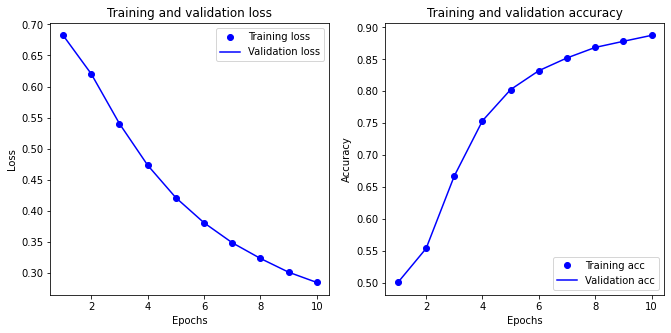

In [14]:
def plot_history(history):
    
    plt.figure(figsize=(11, 5))
    
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['loss']

    #
    # loss
    #
    plt.subplot(1, 2, 1)
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    #
    # accuracy
    #
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    
plot_history(history)

## Evaluación

In [15]:
results = model.evaluate(test_batches)
for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

    782/Unknown - 13s 16ms/step - loss: 0.3315 - accuracy: 0.8630loss: 0.332
accuracy: 0.863
